# Titanic

## 项目介绍
这是Taggle上的第一篇教程性质的项目，  1912年的泰坦尼克沉船事件导致1502名游客的死亡，而船上共有2224名游客。现在，我们掌握了船上乘客的一些数据和乘客是否获救的信息，通过对数据进行分析以及机器学习方法，最后我们要做到的是对任意一个从未出现在给定数据的乘客，预测他是否获救  
- 通过该项目，对数据处理，特征工程，以及机器学习应用等方面产生一个较为清晰的认识。  
- 同时，由于是教学性质的文章，我会对一些代码写尽可能详细的注释，便于理解和学习。

## 目录

1. 数据分析
2. 特征工程
3. baseline

## 1. 数据分析
首先，将给定数据导入到程序中，然后对给定的每个特征，进行简要的分析和可视化，从而探索出数据，特征之间的关系，为之后的特征工程做准备。

### 1.1 包导入
我们会使用总共三大类的python lib，1.数据处理； 2.可视化； 3.机器学习

In [225]:
#数据处理
import os
import pandas as pd
import numpy as np
import random
import sklearn.preprocessing as preprocessing

#可视化
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#ML
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import (GradientBoostingClassifier, GradientBoostingRegressor, 
                              RandomForestClassifier, RandomForestRegressor)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import precision_score
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
import warnings
warnings.filterwarnings('ignore')


### 1.2 数据探索
首先看一下数据的大概状况

In [226]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


对于每个乘客，共有11个特征，以及对应的每个乘客是否获救的label.  
乘客信息如下
- PassengerId = 乘客ID
- Pclass = 乘客等级（1/2/3等仓）
- Name,Sex, Age
- SibSp = 兄弟姐妹个数
- Parch = 父母和小孩个数
- Ticket = 船票信息
- Fare = 船票价格
- Cabin = 客仓
- Embarked = 登船港口  

接下来，对每个特征看一下类型信息

In [227]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


通过以上信息，我们发现在给定数据中，Age，Cabin， Embarked存在**数据缺失**，尤其Cabin缺失很严重    
我们继续对所有的数值数据进行探索：

In [228]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


观察下各个特征之间的协方差

Text(0.5,1,'train feature corr')

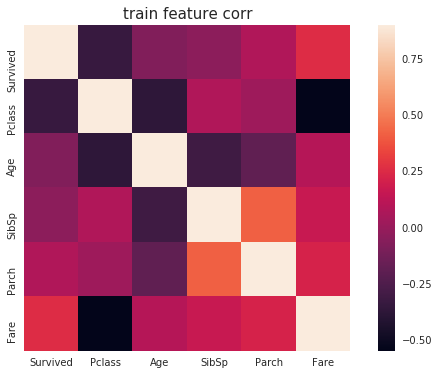

In [229]:
sns.set(context="paper", font="monospace")
sns.set(style="white")
f, ax = plt.subplots(figsize=(10,6))
train_corr = train.drop('PassengerId',axis=1).corr()
sns.heatmap(train_corr, ax=ax, vmax=.9, square=True)
# ax.set_xticklabels(train_corr.index, size=15)
# ax.set_yticklabels(train_corr.columns[::-1], size=15)
ax.set_title('train feature corr', fontsize=15)

通过协方差，我们可以得出以下结论：
- Pclass乘客等级和获救**负相关**
- Fare价格和获救**正相关**，给的钱多的优先
- Pclass和Fare负相关，正常，一等仓最贵

#### 1.2.1 年龄特征分析：
对乘客的年龄特征进行分析，首先画出年龄分布曲线，对于缺失值，使用age=-20进行填补

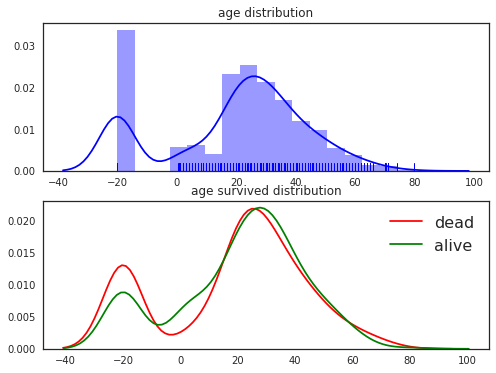

In [230]:
from scipy import stats
fig, axes = plt.subplots(2,1,figsize=(8,6))
sns.distplot(train.Age.fillna(-20), rug=True, color='b', ax=axes[0])
ax0 = axes[0]
ax0.set_title('age distribution')
ax0.set_xlabel('')

ax1 = axes[1]
ax1.set_title('age survived distribution')
k1 = sns.distplot(train[train.Survived==0].Age.fillna(-20), hist=False, color='r', ax=ax1, label='dead')
k2 = sns.distplot(train[train.Survived==1].Age.fillna(-20), hist=False, color='g', ax=ax1, label='alive')
ax1.set_xlabel('')
ax1.legend(fontsize=16)


通过对年龄分布进行分析，可以得到以下信息：
1. 可以看出，小孩和20多岁的青年以及中年获救可能性较大
2. 获救情况和年龄**不成现线性关系，所以如果使用线性模型需要对年龄进行离散处理，作为类型变量带入模型**
3. 获救的人中，年龄缺少的人比例要小于有年龄信息的人（获救之后对乘客信息重新登记导致？）

##### 1.2.1 年龄和性别分布
对年龄和性别两个特征进行探索

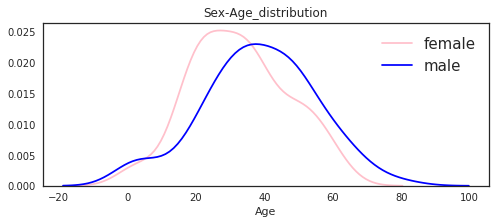

In [231]:
f, ax = plt.subplots(figsize=(8, 3))
ax.set_title('Sex-Age_distribution')
sns.distplot(train[train['Sex'] == 'female'].dropna().Age, hist=False, color='pink', label='female')
sns.distplot(train[train['Sex'] == 'male'].dropna().Age, hist=False, color='blue', label='male')
ax.legend(fontsize=15)

- 男性年龄普遍集中在40岁左右，女性年龄普遍集中在21，22岁左右。
- 老年人中，男性比例较多，年轻人中，女性比例较多。

##### 1.2.1 年龄和仓位分布

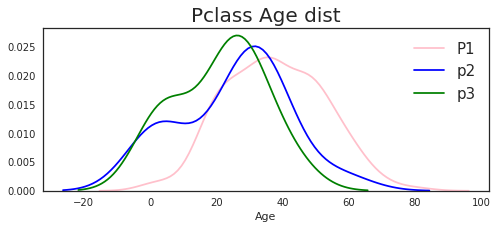

In [232]:
f, ax = plt.subplots(figsize=(8,3))
ax.set_title('Pclass Age dist', size=20)
sns.distplot(train[train.Pclass==1].dropna().Age, hist=False, color='pink', label='P1')
sns.distplot(train[train.Pclass==2].dropna().Age, hist=False, color='blue', label='p2')
sns.distplot(train[train.Pclass==3].dropna().Age, hist=False, color='g', label='p3')
ax.legend(fontsize=15)

- 越老，仓位越好（好像是废话）

#### 1.2.1 Pclass 仓位分析

Text(0.5,1,'Pclass Surveved count')

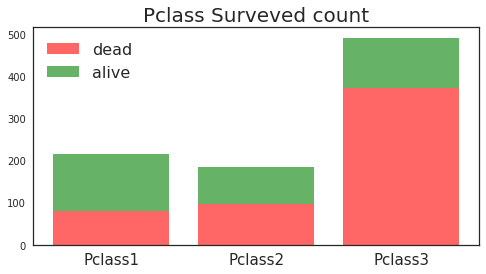

In [233]:
y_dead = train[train.Survived==0].groupby('Pclass')['Survived'].count()
y_alive = train[train.Survived==1].groupby('Pclass')['Survived'].count()
pos = [1, 2, 3]
ax = plt.figure(figsize=(8,4)).add_subplot(111)
ax.bar(pos, y_dead, color='r', alpha=0.6, label='dead')
ax.bar(pos, y_alive, color='g', bottom=y_dead, alpha=0.6, label='alive')
ax.legend(fontsize=16, loc='best')
ax.set_xticks(pos)
ax.set_xticklabels(['Pclass%d'%(i) for i in range(1,4)], size=15)
ax.set_title('Pclass Surveved count', size=20)

- 头等舱（Pclass=1），商务舱（Pclass=2），经济舱（Pclass=3）
- 经济舱人数遥遥领先
- 比较来说，头等舱获救比例最大，经济舱死亡概率最大

In [234]:
# pos = range(0,6)
# age_list = []
# for Pclass_ in range(1,4):
#     for Survived_ in range(0,2):
#         age_list.append(train[(train.Pclass == Pclass_)&(train.Survived == Survived_)].Age.values)

# fig, axes = plt.subplots(3,1,figsize=(10,6))

# i_Pclass = 1
# for ax in axes:
#     sns.distplot(age_list[i_Pclass*2-2], hist=False, ax=ax, label='Pclass:%d ,survived:0'%(i_Pclass), color='r')
#     sns.distplot(age_list[i_Pclass*2-1], hist=False, ax=ax, label='Pclass:%d ,survived:1'%(i_Pclass), color='g')
#     i_Pclass += 1
#     ax.set_xlabel('age', size=15)
#     ax.legend(fontsize=15)

#### 1.2.3 性别特征

In [235]:
print(train.Sex.value_counts())
print('===================================')
print(train.groupby('Sex')['Survived'].mean())

male      577
female    314
Name: Sex, dtype: int64
Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64


可以看出：
- 全部乘客中，男性人数大于女性，接近1.5倍
- 获救乘客中，大部分为女性，是男性的4倍，女性生存率远大于男性

##### 性别和年龄和生存情况

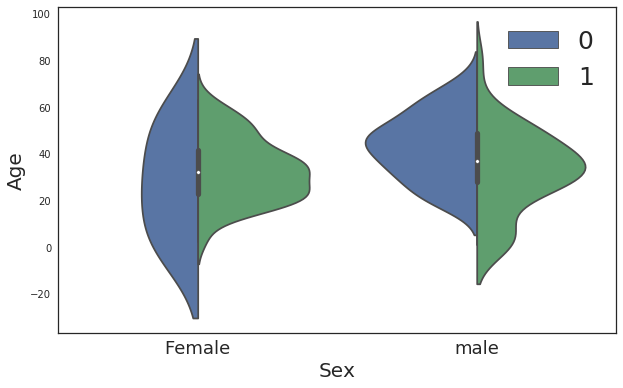

In [236]:
ax = plt.figure(figsize=(10, 6)).add_subplot(111)
sns.violinplot(x='Sex', y='Age', hue='Survived', data=train.dropna(),split=True)
ax.set_xlabel('Sex', size=20)
ax.set_xticklabels(['Female', 'male'], size=18)
ax.set_ylabel('Age', size=20)
ax.legend(fontsize=25, loc='best')

从分布可以看出：
- 女性获救年龄主要分布在20岁左右的青年
- 青年男性获救概率要大于中年男性，年轻人和小孩更容易获救

##### 性别仓位和获救情况分布

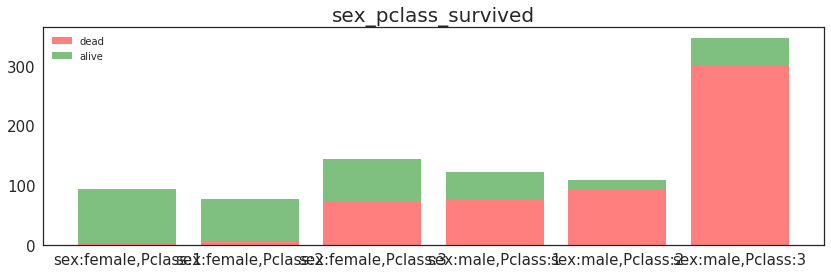

In [237]:
label = []
for sex_i in ['female','male']:
    for pclass_i in range(1,4):
        label.append('sex:%s,Pclass:%d'%(sex_i, pclass_i))
        
pos = range(6)
fig = plt.figure(figsize=(14,4))
ax = fig.add_subplot(111)
ax.bar(pos, 
        train[train['Survived']==0].groupby(['Sex','Pclass'])['Survived'].count().values, 
        color='r', 
        alpha=0.5, 
        align='center',
        tick_label=label, 
        label='dead')
ax.bar(pos, 
        train[train['Survived']==1].groupby(['Sex','Pclass'])['Survived'].count().values, 
        bottom=train[train['Survived']==0].groupby(['Sex','Pclass'])['Survived'].count().values,
        color='g',
        alpha=0.5,
        align='center',
        tick_label=label, 
        label='alive')
ax.tick_params(labelsize=15)
ax.set_title('sex_pclass_survived', size=20)
ax.legend(fontsize=10,loc='best')

可以发现，头等舱的女性几乎都获救了

#### 1.2.4 票价(Fare)
分别看一下票价的分布以及票价随仓位的分布

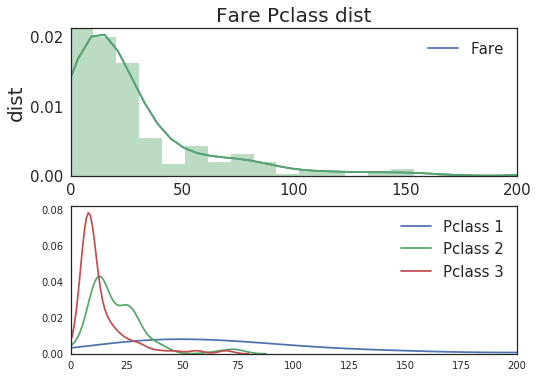

In [238]:
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot2grid((2,2), (0,0), colspan=2)

ax.tick_params(labelsize=15)
ax.set_title('Fare dist', size=20)
ax.set_ylabel('dist', size=20)
sns.kdeplot(train.Fare, ax=ax)
sns.distplot(train.Fare, ax=ax)
ax.legend(fontsize=15)
pos = range(0,400,50)
ax.set_xticks(pos)
ax.set_xlim([0, 200])
ax.set_xlabel('')

ax1 = plt.subplot2grid((2,2), (1,0), colspan=2)
ax.set_title('Fare Pclass dist', size=20)
for i in range(1,4):
    sns.kdeplot(train[train.Pclass==i].Fare, ax=ax1, label='Pclass %d'%(i))
ax1.set_xlim([0,200])
ax1.legend(fontsize=15)

##### 票价和获救情况的关系

Text(0.5,0,'Fare')

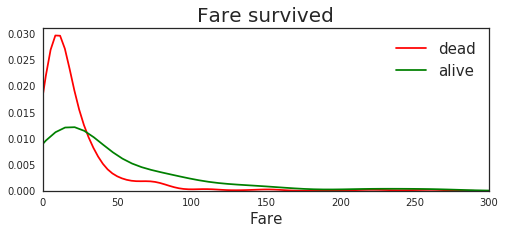

In [239]:
fig = plt.figure(figsize=(8,3))
ax1 = fig.add_subplot(111)
sns.kdeplot(train[train.Survived==0].Fare, ax=ax1, label='dead', color='r')
sns.kdeplot(train[train.Survived==1].Fare, ax=ax1, label='alive', color='g')
#sns.distplot(train[train.Survived==0].Fare, ax=ax1, color='r')
#sns.distplot(train[train.Survived==1].Fare, ax=ax1, color='g')
ax1.set_xlim([0,300])
ax1.legend(fontsize=15)
ax1.set_title('Fare survived', size=20)
ax1.set_xlabel('Fare', size=15)

#### 1.2.5 sibsp&parch 表亲和直亲

Text(0.5,1,'Parch')

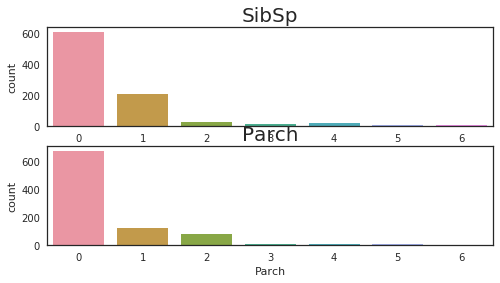

In [240]:
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(211)
sns.countplot(train.SibSp)
ax1.set_title('SibSp', size=20)
ax2 = fig.add_subplot(212, sharex=ax1)
sns.countplot(train.Parch)
ax2.set_title('Parch', size=20)

Text(0.5,1,'Parch+Sibsp Survived Rate')

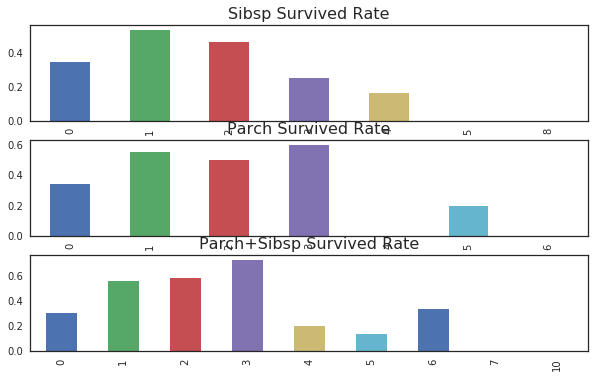

In [241]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(311)
train.groupby('SibSp')['Survived'].mean().plot(kind='bar', ax=ax1)
ax1.set_title('Sibsp Survived Rate', size=16)
ax1.set_xlabel('')

ax2 = fig.add_subplot(312)
train.groupby('Parch')['Survived'].mean().plot(kind='bar', ax=ax2)
ax2.set_title('Parch Survived Rate', size=16)
ax2.set_xlabel('')

ax3 = fig.add_subplot(313)
train.groupby(train.SibSp+train.Parch)['Survived'].mean().plot(kind='bar', ax=ax3)
ax3.set_title('Parch+Sibsp Survived Rate', size=16)

分组统计不同人数亲戚的获救率来看，都近似呈现先高后低, 亲人数目多少和是否获救不是简单的线性关系
#### 1.2.6 Embarked 上船地点

Text(0.5,1,'Embarked survived count')

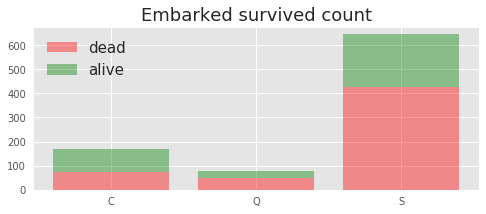

In [242]:
plt.style.use('ggplot')
ax = plt.figure(figsize=(8,3)).add_subplot(111)
pos = [1, 2, 3]
y1 = train[train.Survived==0].groupby('Embarked')['Survived'].count().sort_index().values
y2 = train[train.Survived==1].groupby('Embarked')['Survived'].count().sort_index().values
ax.bar(pos, y1, color='r', alpha=0.4, align='center', label='dead')
ax.bar(pos, y2, color='g', alpha=0.4, align='center', label='alive', bottom=y1)
ax.set_xticks(pos)
ax.set_xticklabels(['C','Q','S'])
ax.legend(fontsize=15, loc='best')
ax.set_title('Embarked survived count', size=18)

可以看出，从c港上船的乘客更容易获救

Text(0.5,1,'Embarked Age Dist ')

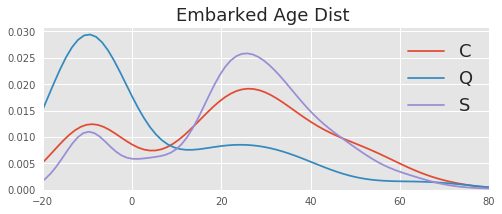

In [243]:
ax = plt.figure(figsize=(8,3)).add_subplot(111)
ax.set_xlim([-20, 80])
sns.kdeplot(train[train.Embarked=='C'].Age.fillna(-10), ax=ax, label='C')
sns.kdeplot(train[train.Embarked=='Q'].Age.fillna(-10), ax=ax, label='Q')
sns.kdeplot(train[train.Embarked=='S'].Age.fillna(-10), ax=ax, label='S')
ax.legend(fontsize=18)
ax.set_title('Embarked Age Dist ', size=18)

- Q上岸的很多没有年龄
- C上岸和S上岸的年龄分布较为相似，区别在于C上岸的年龄分布更加扁平，小孩和老人比例更高

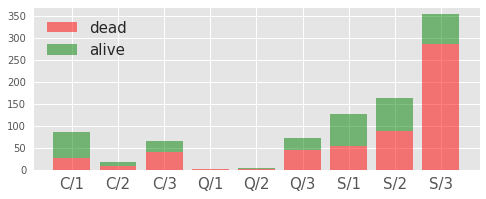

In [244]:
y1 = train[train.Survived==0].groupby(['Embarked','Pclass'])['Survived'].count().reset_index()['Survived'].values
y2 = train[train.Survived==1].groupby(['Embarked','Pclass'])['Survived'].count().reset_index()['Survived'].values

ax = plt.figure(figsize=(8,3)).add_subplot(111)
pos = range(9)
ax.bar(pos, y1, align='center', alpha=0.5, color='r', label='dead')
ax.bar(pos, y2, align='center', bottom=y1, alpha=0.5, color='g', label='alive')

ax.set_xticks(pos)
xticklabels = []
for embarked_val in ['C','Q','S']:
    for pclass_val in range(1,4):
        xticklabels.append('%s/%d'%(embarked_val,pclass_val))

ax.set_xticklabels(xticklabels,size=15)
ax.legend(fontsize=15, loc='best')

从不同仓位的比例来看，似乎C上岸更容易获救是因为头等舱的人较多？

但进一步对比C/S 发现，同样的仓位，C获救概率依然更高

脑洞下：

C地的人更加抱团，互帮互助- -
人数上来看S地的人更多，不同等级分布也更合常理，而C地的人头等舱很多，商务舱几乎没有，屌丝仓的也不少；


猜想：C地的人更多是权贵，S地的人来自商贸发达的商人？，所有C地的人地位更高- -

#### 1.2.7 Cabin 船舱号

In [245]:
train.Cabin.isnull().value_counts()

True     687
False    204
Name: Cabin, dtype: int64

In [246]:
train.groupby(by=train.Cabin.isnull())['Survived'].mean()

Cabin
False    0.666667
True     0.299854
Name: Survived, dtype: float64

- Cabin大部分为空
- 为空的获救概率较低，不为空的获救概率较高。**说明该数据可以作为特征**

In [247]:
train[train.Cabin.apply(lambda x:len(x) if(x is not np.nan) else 0)>4].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0000,C23 C25 C27,S
75,76,0,3,"Moen, Mr. Sigurd Hansen",male,25.0,0,0,348123,7.6500,F G73,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.0000,C23 C25 C27,S
97,98,1,1,"Greenfield, Mr. William Bertram",male,23.0,0,1,PC 17759,63.3583,D10 D12,C
118,119,0,1,"Baxter, Mr. Quigg Edmond",male,24.0,0,1,PC 17558,247.5208,B58 B60,C


不少船舱编号有多个，其个数基本上和直系亲属个数保持一致，说明也许可以通过寻找亲属信息来填充cabin的一部分信息

In [248]:
train['Cabin_Zone'] = train.Cabin.fillna('0').str.split(' ').apply(lambda x: x[0][0])
train.groupby(by='Cabin_Zone')['Survived'].agg(['mean', 'count'])

,mean,count
Cabin_Zone,,
0,0.299854,687
A,0.466667,15
B,0.744681,47
C,0.593220,59
D,0.757576,33
E,0.750000,32
F,0.615385,13
G,0.500000,4
T,0.000000,1


把每个Cabin中的区域提取出来之后，统计发现不同区域获救概率差别很大，**或许可以作为一个特征**

#### 1.2.8 姓名特征
最开始认为Name这个特征没有任何意义，但我们发现，所给数据中的姓名信息不仅仅是姓名，而且包括称谓，甚至包括性别，地位，财富，婚姻状况等都可能包含在姓名中。所以，对于Name不能直接将其当作垃圾特征处理。  
首先，对姓名的长度和获救状况进行探索：














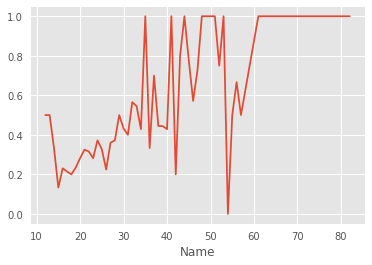

In [249]:
train.groupby(train.Name.apply(lambda x:len(x)))['Survived'].mean().plot()

- 可以发现，似乎名字越长，获救可能性越高，所以我们把名字的长度加入特征：

In [250]:
train['Name_Len'] = train['Name'].apply(lambda x:len(x))
test['Name_Len'] = test['Name'].apply(lambda x:len(x))
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_Zone,Name_Len
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,23
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C,51
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,22


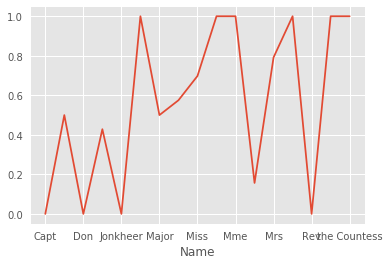

In [251]:
train.groupby(train['Name'].apply(lambda x: x.split(', ')[1]).apply(lambda x: x.split('.')[0]))['Survived'].mean().plot()

于是我们把称谓信息提取出来，由于有些称谓的人数量过少，我们还需要做一个映射:

Mme：称呼非英语民族的"上层社会"已婚妇女,及有职业的妇女，相当于Mrs

Jonkheer:乡绅

Capt：船长

Lady：贵族夫人的称呼

Don唐：是西班牙语中贵族和有地位者的尊称

sir：先生

the Countess：女伯爵

Ms：Ms.或Mz 美国近来用来称呼婚姻状态不明的妇女

Col：中校:Lieutenant Colonel(Lt. Col.)上校:Colonel(Col.)

Major：少校

Mlle:小姐

Rev：牧师

测试集合中特殊的Dona：女士尊称

In [252]:
train['Title'] = train['Name'].apply(lambda x: x.split(', ')[1]).apply(lambda x: x.split('.')[0])
train['Title'] = train['Title'].replace(['Don','Dona', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col','Sir','Dr'],'Mr')
train['Title'] = train['Title'].replace(['Mlle','Ms'], 'Miss')
train['Title'] = train['Title'].replace(['the Countess','Mme','Lady','Dr'], 'Mrs')

test['Title'] = test['Name'].apply(lambda x: x.split(', ')[1]).apply(lambda x: x.split('.')[0])
test['Title'] = test['Title'].replace(['Don','Dona', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col','Sir','Dr'],'Mr')
test['Title'] = test['Title'].replace(['Mlle','Ms'], 'Miss')
test['Title'] = test['Title'].replace(['the Countess','Mme','Lady','Dr'], 'Mrs')

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_Zone,Name_Len,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,23,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C,51,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,22,Miss


# 2. 特征工程
首先查看所有数据中为null的数据：


In [253]:
print('============train===========')
print(train.isnull().sum())
print('============test============')
print(test.isnull().sum())

============train===========
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Cabin_Zone       0
Name_Len         0
Title            0
dtype: int64
============test============
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
Name_Len         0
Title            0
dtype: int64


1. age 和 cabin在训练集和测试集都有缺失，cabin缺失数量巨大
2. embarked 在训练集存在2个缺失
3. fare在测试集有一个缺失

### 2.1 embarked 处理
首先，对embarked进行处理，查看embarked的缺失情况。  
因为只有2个数据存在缺失，所以不适合将“缺失”重新定义一个分类，我们想办法对其进行填补：

In [254]:
train[train.Embarked.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_Zone,Name_Len,Title
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,B,19,Miss
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,B,41,Mrs


In [255]:
print(train.Embarked.value_counts())
print('=========================')
print(train[train.Pclass==1].Embarked.value_counts())

S    644
C    168
Q     77
Name: Embarked, dtype: int64
S    127
C     85
Q      2
Name: Embarked, dtype: int64


- 不分Pclass仓位来看的话，S embarked人数远大于C，Q
- 而且两个缺失的数据Pclass都为1，而Pclass==1的乘客中，S embarked的人数也是最多。  

**所以，因为缺失数据很少，可以考虑随最大可能数据填补缺失值，因此设定缺失值为S**

In [256]:
train.Embarked.fillna('S', inplace=True)

### 2.2 cabin处理
在之前的数据探索环节，我们知道cabin为空的获救概率较低，不为空的获救概率较高。说明该数据可以作为特征。所以我们对cabin作填充处理

In [257]:
#若为NaN,则用字符串‘Null’填充，否则用'Not Null'填充
train['Cabin'] = train['Cabin'].isnull().apply(lambda x: 'Null' if x is True else 'Not Null')
test['Cabin'] = test['Cabin'].isnull().apply(lambda x: 'Null' if x is True else 'Not Null')

### 2.3 Name和Ticket处理
已经从Name属性中提取了有价值的特征，所以删除原Name和Ticket属性

In [258]:
del train['Name'], test['Name']
del train['Ticket'], test['Ticket']

### 2.4 年龄离散化处理
在我们对数据进行观察时，发现获救情况和年龄不是存在简单的线性关系，所以需要对年龄进行离散化处理   
同时，对于缺失值，需要进行填补。考虑到年龄缺失的数量较多，所以将缺失设为一类   
年龄以5岁为一个周期进行离散，同时10岁以下，60岁以上分别归为一类

In [259]:
group = train.groupby(['Title', 'Pclass'])['Age']
train['Age'] = group.transform(lambda x: x.fillna(x.median()))
train = train.drop('Title',axis=1)
train['IsChild'] = np.where(train['Age']<=12,1,0)
train['Age'] = pd.cut(train['Age'],5)
#train = train.drop('Age',axis=1)


group = test.groupby(['Title', 'Pclass'])['Age']
test['Age'] = group.transform(lambda x: x.fillna(x.median()))
test = test.drop('Title',axis=1)
test['IsChild'] = np.where(test['Age']<=12,1,0)
test['Age'] = pd.cut(test['Age'],5)
#test = test.drop('Age',axis=1)

train.head(3)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Cabin_Zone,Name_Len,IsChild
0,1,0,3,male,"(16.336, 32.252]",1,0,7.2500,Null,S,0,23,0
1,2,1,1,female,"(32.252, 48.168]",1,0,71.2833,Not Null,C,C,51,0
2,3,1,3,female,"(16.336, 32.252]",0,0,7.9250,Null,S,0,22,0


### 2.5 fare属性
在test集中存在一个数据的fare为缺失值，对于这个变量，可以用平均值进行填补

In [260]:
test[test.Fare.isnull()]

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Name_Len,IsChild
152,1044,3,male,"(45.668, 60.834]",0,0,NaN,Null,S,18,0


In [261]:
test.loc[test.Fare.isnull(), 'Fare'] = \
test[(test.Pclass==1) & (test.Embarked=='S') & (test.Sex=='male')].dropna().Fare.mean()

### 2.6 归一化处理
数据中fare分布波动较大，对其进行归一化处理，加速模型收敛

In [262]:
scaler = preprocessing.StandardScaler()
fare_scale_param = scaler.fit(train['Fare'].values.reshape(-1, 1))
train.Fare = fare_scale_param.transform(train['Fare'].values.reshape(-1, 1))
test.Fare = fare_scale_param.transform(test['Fare'].values.reshape(-1, 1))

### 2.7 所有特征转化成数值型编码

In [271]:
features = train.drop(["PassengerId","Survived"], axis=1).columns
le = LabelEncoder()
for feature in features:
    le = le.fit(train[feature])
    train[feature] = le.transform(train[feature])
    
train.head(3)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Cabin_Zone,Name_Len,IsChild
0,1,0,2,1,1,1,0,18,1,2,0,11,0
1,2,1,0,0,2,1,0,207,0,0,3,39,0
2,3,1,2,0,1,0,0,41,1,2,0,10,0


### 2.8 得到训练/测试数据集

In [275]:
X_all = train.iloc[:891,:].drop(['PassengerId', 'Survived'], axis=1)
Y_all = train.iloc[:891,:]['Survived']
X_test = train.iloc[891:,:].drop(['PassengerId', 'Survived'], axis=1)

# 3 模型训练和调优
分别考察逻辑回归、支持向量机、最近邻、决策树、随机森林、gbdt、xgbGBDT几类算法的性能。

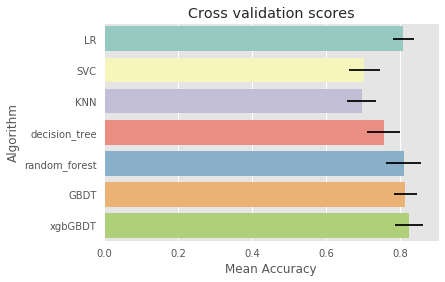

In [278]:
lr = LogisticRegression()
svc = SVC()
knn = KNeighborsClassifier(n_neighbors = 3)
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier(n_estimators=300,min_samples_leaf=4,class_weight={0:0.745,1:0.255})
gbdt = GradientBoostingClassifier(n_estimators=500,learning_rate=0.03,max_depth=3)
xgbGBDT = XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05)
clfs = [lr, svc, knn, decision_tree, random_forest, gbdt, xgbGBDT]

kfold = 10
cv_results = []
for classifier in clfs :
    cv_results.append(cross_val_score(classifier, X_all, y = Y_all, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,
                       "Algorithm":["LR","SVC",'KNN','decision_tree',"random_forest","GBDT","xgbGBDT"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

通过观察，发现不同的模型的feature importance有比较大的差别，所以考虑到把他们组合在一起可能有更好的效果  
首先定义集成框架：

In [279]:
class Ensemble(object):
    
    def __init__(self,estimators):
        self.estimator_names = []
        self.estimators = []
        for i in estimators:
            self.estimator_names.append(i[0])
            self.estimators.append(i[1])
        self.clf = LogisticRegression()
    
    def fit(self, train_x, train_y):
        for i in self.estimators:
            i.fit(train_x,train_y)
        x = np.array([i.predict(train_x) for i in self.estimators]).T
        y = train_y
        self.clf.fit(x, y)
    
    def predict(self,x):
        x = np.array([i.predict(x) for i in self.estimators]).T
        #print(x)
        return self.clf.predict(x)
        
    
    def score(self,x,y):
        s = precision_score(y,self.predict(x))
        return s

将基分类器放入集成框架中。

In [282]:
bag = Ensemble(
    [('xgb',xgbGBDT),('lr',lr),('rf',random_forest),('svc',svc),('gbdt',gbdt),('dt',decision_tree),('knn',knn)])
score = 0
for i in range(0,10):
    num_test = 0.20
    X_train, X_cv, Y_train, Y_cv = train_test_split(X_all, Y_all, test_size=num_test)
    bag.fit(X_train, Y_train)
    #Y_test = bag.predict(X_test)
    acc_xgb = round(bag.score(X_cv, Y_cv) * 100, 2)
    score+=acc_xgb
print(score/10)  #0.8786

68.73299999999999


In [ ]:
# def plot_learning_curve(clf, title, X, y, ylim=None, cv=None, n_jobs=3, train_sizes=np.linspace(.05, 1., 5)):
#     train_sizes, train_scores, test_scores = learning_curve(
#         clf, x, y, train_sizes=train_sizes)
#     train_scores_mean = np.mean(train_scores, axis=1)
#     train_scores_std = np.std(train_scores, axis=1)
#     test_scores_mean = np.mean(test_scores, axis=1)
#     test_scores_std = np.std(test_scores, axis=1)
    
#     ax = plt.figure().add_subplot(111)
#     ax.set_title(title)
#     if ylim is not None:
#         ax.ylim(*ylim)
#     ax.set_xlabel(u"train_num_of_samples")
#     ax.set_ylabel(u"score")

#     ax.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
#                      alpha=0.1, color="b")
#     ax.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
#                      alpha=0.1, color="r")
#     ax.plot(train_sizes, train_scores_mean, 'o-', color="b", label=u"train score")
#     ax.plot(train_sizes, test_scores_mean, 'o-', color="r", label=u"testCV score")

#     ax.legend(loc="best")

#     midpoint = ((train_scores_mean[-1] + train_scores_std[-1]) + (test_scores_mean[-1] - test_scores_std[-1])) / 2
#     diff = (train_scores_mean[-1] + train_scores_std[-1]) - (test_scores_mean[-1] - test_scores_std[-1])
#     return midpoint, diff

# plot_learning_curve(grd, u"learning_rate", train_x, train_y)

# gender_submission = pd.DataFrame({'PassengerId':test.iloc[:,0],'Survived':grd.predict(test_x)})
# gender_submission.to_csv('C:/Users/evilpsycho/Desktop/gender_submission.csv', index=None)